In [1]:
using LinearAlgebra, JuMP, CPLEX, Ipopt, Plots, Distributions, Printf

# Computing State-space Model from transfer function

$$ y(s) = \dfrac{1}{125s^3 + 75s^2 + 15s + 1} \ u(s) $$

State-space representation from the transfer function above (from matlab):

In [2]:
A_drto = [2.45619225923395 -2.01096013810692 0.548811636094027; 
    1 0 0;
    0 1 0]
# uncertainty in B matrix
# B_drto = [0.0625; 0; 0] # nominal
C_drto = [0.0183756999177941, 0.0633113580621751, 0.0136128264831647];

System configuration

In [3]:
# Sampling time
T = 1
# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1
# Number of states
nx = 3;

DRTO configuration

In [4]:
# Prediction horizon 30 | 50
pD = 50
# Input control horizon 
mD = 20
# DRTO sampling time
nDRTO = 5

# setting bounds 
ΔUMax = 0.3
uMax = 1.2
uMin = 0.0
yMax = 1.5
yMin = 0.0
yspMax = 1.5
yspMin = 0.0

# setting initial values
x0 = [0.0;0.0;0.0]
y0 = C_drto'*[0.0;0.0;0.0]
u0 = 0.0;

# Building MPC model

Controller configuration

In [5]:
# Output prediction horizon
p = 30 #30
# Input control horizon 
m = 3
# Output weights
q = 1
# Input weights aggressive = 1 | detuned = 20
r = 1;

In [6]:
A = A_drto
B = [0.0625; 0; 0] # using nominal model 
C = C_drto;

In [7]:
Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
Bd = [B; 0]
Cd = [C; 1];

In [8]:
Psi = Cd'*Ad
for ii in 2:p
    Psi = [Psi;  Cd'*Ad^ii]
end

# Computing Dynamic Matirx
a = [Cd'*Ad^(ii - 1)*Bd for ii in 1:p];
DynM = a

for ii in 1:(m - 2)
    a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
    DynM = [DynM  a]
end

# adjusting dynamic matrix for since p > m (last column)
b = Cd'*Bd

Ai = I(nx+1) # adding disturbance to the states
for ii = 1:(p - m)
    Ai = Ai + Ad^ii
    b = [b;Cd'*Ai*Bd]
end

Theta=[DynM [zeros(ny*(m-1),nu);b]];

In [9]:
# Creating Qbar and Rbar matrices
Qbar = Diagonal([q for ii in 1:p])
Rbar = Diagonal([r for ii in 1:m])

# Creating input movement OF penalty matrix 
M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
Ibar=[I(nu); zeros(nu*(m-1),nu)]
IM = I(nu*m) - M';

In [10]:
# Matrix H
H = Theta'*Qbar*Theta + IM'*Rbar*IM;

# Constrained MPC 

In [11]:
# matrix to compute the gradients of the input bound constraints (hardcoded - specific for this system)
conMatrix = [1 0 0;
             0 1 0;
             0 0 1]; 

# big-M implementation
bigM = 1000;

# Infeasible solution

from decomposition file: Decomposed_CLDRTO_con_bin.ipynb

In [12]:
Y_A = [0.0 0.0 1.0;
 0.0  0.0  1.0;
 1.0  1.0  0.0;
 1.0  1.0  0.0;
 1.0  1.0  0.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 1.0  1.0  0.0;
 1.0  1.0  0.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0;
 0.0  0.0  1.0]

Y_B = [0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 1.0  1.0  1.0
 1.0  1.0  0.0
 0.0  0.0  1.0]

Y_C = [ 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0]

Y_D = [
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  1.0  0.0
 1.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  0.0  1.0]

ysp_fixed = [1.5 1.5 1.5 1.5 1.5]

#B_drto_s = [0.0539409  0.0570459
#             0.0 0.0
#             0.0 0.0];


B_drto_s = [0.0662265 0.0535349
             0.0 0.0
             0.0 0.0];

#B_drto_s = [0.0561444  0.0624903
#             0.0 0.0
#             0.0 0.0];

## Modeling Subproblem

In [13]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,ysp_fixed,Y_u_fixed,scen,pScen,B_drto_s,relaxed)
    ###########
    # inputs: #
    ###########
    # xInit - states at the current iteration (beginning of DRTO horizon)
    # uInit - inputs at the current iteration, already implemented on the plant
    # ysp_fixed - non-antecipativity constraints (first nDRTO setpoints must be equal among scenarios)
    # Y_(u,l)_fixed - binary variables to solve the MPC optimization problems
    # scen - which scenario the subproblem represents
    # pScen - probability of the scenarios
    # B_drto_s - uncertainty realization
    # relax - 0 solve regular problem | 1 solve always feasible problem

    # Define subproblem model
    sub = Model(CPLEX.Optimizer)
    set_silent(sub) # avoid printing

    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(sub, xDRTO[1:pD, 1:nx])
    @variable(sub, yDRTO[1:pD])
    
    # MPC model variables
    @variable(sub, xMPC[1:pD, 1:nx])
    @variable(sub, yMPC[1:pD])

    # MPC <-> DRTO model deviation
    @variable(sub, de[1:pD])
    
    # inputs computed by MPCs
    @variable(sub, u[1:pD,1:m])
    
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, yspMin ≤ ysp[1:pD] ≤ yspMax)
    
    # upper bounds for inputs
    @variable(sub, mu_g[1:mD,1:m] ≥ 0.0)
    
    # ''Binaries'' for big-M implementation (here relaxed as real numbers)
    @variable(sub, Y_ub[1:mD,1:m]) 
    
    # slacks for controlling setpoint into a zone and for always feasible problem
    @variable(sub, delta_y_p[1:pD] ≥ 0.0)
    @variable(sub, delta_y_m[1:pD] ≥ 0.0)    
    
    ######################################
    # Set up constraints and expressions #
    ######################################
    # Dynamic RTO model (linear)
    @constraint(sub, CLDRTO_dyn_model_1, xDRTO[1,:] .== A_drto*xInit + B_drto_s[:,scen]*uInit)
    @constraint(sub, CLDRTO_dyn_model[kk=1:(pD - 1)], xDRTO[kk + 1,:] .== A_drto*xDRTO[kk,:] + B_drto_s[:,scen]*u[kk,1])
    @constraint(sub, CLDRTO_model_out[kk=1:pD], yDRTO[kk] == C_drto'*xDRTO[kk,:])

    # MPC model (linear)
    @constraint(sub, MPC_dyn_model_1, xMPC[1,:] .== A*xInit + B*uInit)
    @constraint(sub, MPC_dyn_model[kk=1:(pD - 1)], xMPC[kk + 1,:] .== A*xMPC[kk,:] + B*u[kk,1])
    @constraint(sub, MPC_model_out[kk=1:pD], yMPC[kk] == C'*xMPC[kk,:])
    
    #  MPC model deviation (disturance)
    @constraint(sub, MPC_model_dev[kk=1:pD], de[kk] == yDRTO[kk] - yMPC[kk])

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk,1] == u[mD,1]);
    
    # y (DRTO) inside target quality band
    @constraint(sub, target_plus[kk=1:pD], yDRTO[kk] + delta_y_p[kk] >= 0.95)
    @constraint(sub, target_minus[kk=1:pD], yDRTO[kk] - delta_y_m[kk] <= 1.05)
    
    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], ysp[kk] - ysp_fixed[kk] == 0.0);
    
    ################
    # MPC solution #
    ################
    @expression(sub, cfT_1, (Psi*[xMPC[1,:];de[1]] - ysp[1:p])'*Qbar*Theta - uInit'*Ibar'*Rbar*IM)
    @expression(sub, cfT[kk=2:mD], (Psi*[xMPC[kk,:];de[kk]] - ysp[kk:(kk + p - 1)])'*Qbar*Theta - u[kk-1,1]'*Ibar'*Rbar*IM)

        # Constrained with binaries
        # 1. stationarity
        @constraint(sub, MPC_sol_1, u[1,:]'*H + cfT_1 +  mu_g[1,:]'*conMatrix .== 0)
        @constraint(sub, MPC_sol[kk=2:mD], u[kk,:]'*H + cfT[kk] + mu_g[kk,:]'*conMatrix .== 0)

        # 2. primal feasibility
        @constraint(sub, MPC_u_upper[kk=1:mD,uu=1:m], u[kk,uu] - uMax ≤ 0)
    
        # 3. dual feasibility
        #@constraint(sub, MPC_mu_upper[kk=1:mD,uu=1:m], mu_g[kk,uu] ≥ 0)
    
        # 4. complementarity: big-M implementation
        @constraint(sub, bigM_1[kk=1:mD,uu=1:m], mu_g[kk,uu] <= bigM*Y_ub[kk,uu])
        @constraint(sub, bigM_3[kk=1:mD,uu=1:m], u[kk,uu] - uMax >= -bigM*(1 - Y_ub[kk,uu]))
    
        # specifying binaries <-- Master Problem
        @constraint(sub, binMasterU[kk=1:mD,uu=1:m], Y_ub[kk,uu] - Y_u_fixed[kk,uu] == 0.0)
            
    #############################
    # Set up objective function #
    #############################
    # minimize input usage to bring y to target + penalization if output leaves target band
    @objective(sub, Min, pScen*sum(u[kk,1] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))
    
    # @show sub
        
    # checking which version of the subproblem should be solved
    if relaxed == 0

        optimize!(sub)

        # checking status of the solution
        flag_sub = termination_status(sub)
        
        #calling values of the solved problem
        o = objective_value(sub)
        uArray = value.(u)
        yspArray = value.(ysp)
        yArray = value.(yDRTO)
        muArray = value.(mu_g)

        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        μ = dual.(binMasterU)
    
    else #i.e. no feasible solution
        display("Always-feasible subproblem")
        ## ! soft bounds on mu
        delete_lower_bound.(mu_g[1:mD,1:m])
        
        # ! soft bounds on ysp
        delete_lower_bound.(ysp[1:pD])
        delete_upper_bound.(ysp[1:pD])
        
        ####################
        # Set up variables #
        #################### 
        # slacks for always feasible problem
        @variable(sub, delta_ysp_u[1:pD] ≥ 0.0)
        @variable(sub, delta_ysp_l[1:pD] ≥ 0.0)
        @variable(sub, delta_mu[1:mD,1:m] ≥ 0.0)

        ###########################
        # Always-feasible problem #
        ###########################        
        # adding a constraint to guarantee that mu is always feasible
        @constraint(sub, soft_MPC_mu_upper[kk=1:mD,uu=1:m], mu_g[kk,uu] + delta_mu[kk,uu] ≥ 0)
        
        # adding a constraint to guarantee that ysp are always feasible
        @constraint(sub, soft_sp_lower[kk=1:pD], ysp[kk] + delta_ysp_l[kk] ≥ yspMin)
        @constraint(sub, soft_sp_plus[kk=1:pD], ysp[kk] - delta_ysp_u[kk] ≤ yspMax)

        #############################
        # Set up objective function #
        #############################
        # Modifying the objective --> call @objective with the new objective function.
        # minimize input usage to bring y to target + penalization if output leaves target band + always-feasible term
        @objective(sub, Min, pScen*(sum(u[kk,1] 
                                        + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) 
                                        + 5e3*(delta_ysp_l[kk]^2 + delta_ysp_u[kk]^2) 
                                        for kk in 1:pD)
                                        + 5e4*sum(sum(delta_mu[kk,uu]^2 for uu in 1:m) for kk in 1:mD)
            )
        )
 
        # 
        
        #@show sub
        set_optimizer_attribute(sub, "CPX_PARAM_BARALG", 1)

        # re-optimizing (now using the always feasible problem)
        optimize!(sub)
        
        # checking status of the solution
        flag_sub = termination_status(sub)
        
        #calling values of the solved problem
        uArray = value.(u)
        yspArray = value.(ysp)
        yArray = value.(yDRTO)
        muArray = value.(mu_g)
        delta_yspuArray = value.(delta_ysp_u)
        delta_ysplArray = value.(delta_ysp_l)
        delta_muArray = value.(delta_mu)
        
        # retrieving objective function without always-feasible term
        o = objective_value(sub)# - 1e3*sum((delta_ysplArray[kk]^2 + delta_yspuArray[kk]^2) for kk in 1:pD) - 1e4*sum(sum(delta_muArray[kk,uu]^2 for uu in 1:m) for kk in 1:mD)

        # lagrange multipliers associated with the nonantecipativity constraints and binaries from master problem
        λ = dual.(nonAnt)
        μ = dual.(binMasterU)
    end
    
    return Dict('o' => o, 'f' => flag_sub, 'λ' => λ,'μ' => μ,'u' => uArray, 'y' => yArray, 's' => yspArray, 'm' => muArray)
end;

## Tuning always feasible subproblem 

In [14]:
dicSol = subp(x0,u0,ysp_fixed,Y_A,1,0.5,B_drto_s,0)
#dicSol = subp(x0,u0,ysp_fixed,Y_B,2,0.5,B_drto_s,0)
#dicSol = subp(x0,u0,ysp_fixed,Y_C,1,0.5,B_drto_s,0)
#dicSol = subp(x0,u0,ysp_fixed,Y_D,1,0.5,B_drto_s,0)

#display(dicSol['m'])
display(dicSol['o'])

# Extracting solution for plotting
yTraj = Vector{Float64}(undef,pD)
uTraj = Vector{Float64}(undef,pD) 
yspTraj = Vector{Float64}(undef,pD) 

for ii in 1:pD
    yTraj[ii] = dicSol['y'][ii]
    yspTraj[ii] = dicSol['s'][ii]
    uTraj[ii] = dicSol['u'][ii,1]
end;

429857.2978754411

In [15]:
dicSol_R = subp(x0,u0,ysp_fixed,Y_A,1,0.5,B_drto_s,1)
#dicSol_R = subp(x0,u0,ysp_fixed,Y_B,2,0.5,B_drto_s,1)
#dicSol_R = subp(x0,u0,ysp_fixed,Y_C,1,0.5,B_drto_s,1)
#dicSol_R = subp(x0,u0,ysp_fixed,Y_D,1,0.5,B_drto_s,1)

#display(dicSol_R['m'])
display(dicSol_R['o'])

# Extracting solution for plotting
yTraj_R = Vector{Float64}(undef,pD)
uTraj_R = Vector{Float64}(undef,pD) 
yspTraj_R = Vector{Float64}(undef,pD) 

for ii in 1:pD
    yTraj_R[ii] = dicSol_R['y'][ii]
    yspTraj_R[ii] = dicSol_R['s'][ii]
    uTraj_R[ii] = dicSol_R['u'][ii,1]
end;

"Always-feasible subproblem"

420022.93534274533

## Plotting normal vs. relaxed

In [16]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Creating color array
CList = reshape( range(colorant"red", stop=colorant"blue",length=2), 1, 2);

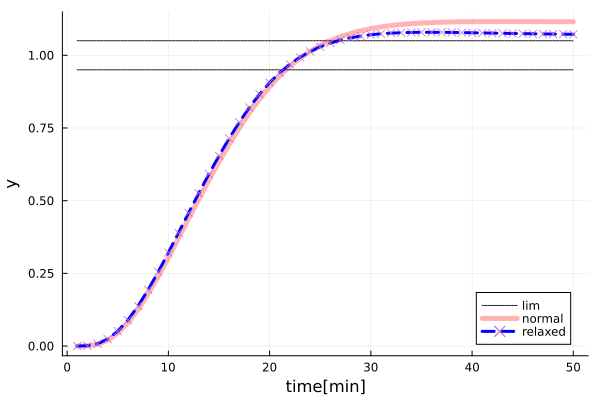

In [17]:
gr()
###########
# OUTPUTS #
###########
# limits
p1 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[min]",yaxis="y")
p1 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)

p1.series_list[1][:label] = "lim"
p1.series_list[2][:label] = ""

p1 = plot!(ts,yTraj,linewidth=5,linealpha = 0.3,linecolor = CList[1])
p1 = plot!(ts,yTraj_R,linewidth=3,linestyle=:dash,markershape=:xcross,linecolor = CList[2])

p1.series_list[3][:label] = "normal"
p1.series_list[4][:label] = "relaxed"

display(p1)

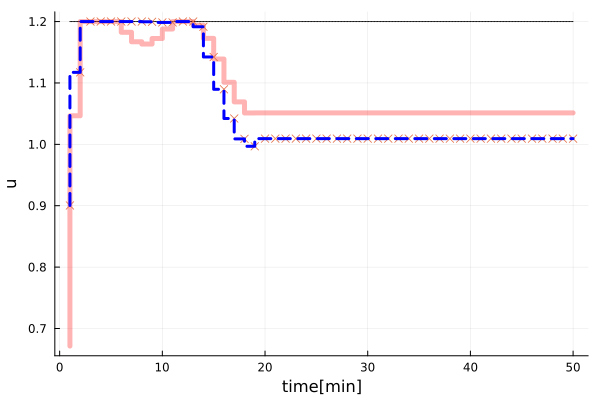

In [18]:
gr()
##########
# INPUTS #
##########
# limits
p2 = plot(ts,uMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[min]",yaxis="u",legend=false)

p2 = plot!(ts,uTraj,linewidth=5,linetype=:steppre,linealpha = 0.3,linecolor = CList[1])
p2 = plot!(ts,uTraj_R,linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = CList[2])

display(p2)

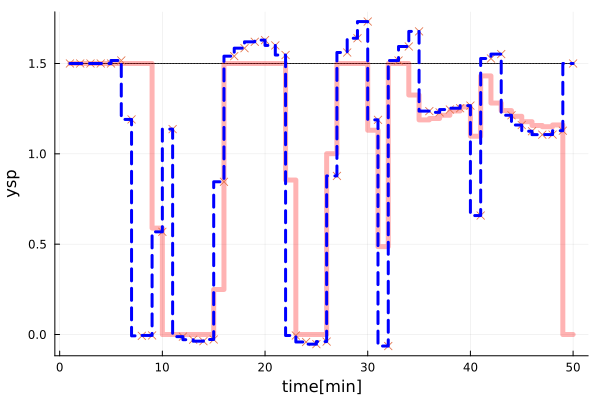

In [19]:
gr()
#############
# SETPOINTS #
#############
# limits
p3 = plot(ts,yspMax*ones(length(ts)),linestyle = :dot,linecolor = :black,xaxis="time[min]",yaxis="ysp",legend=false)

p3 = plot!(ts,yspTraj,linewidth=5,linetype=:steppre,linealpha = 0.3,linecolor = CList[1])
p3 = plot!(ts,yspTraj_R,linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = CList[2])

display(p3)